In [2]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

# For Encoding
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# For missing values
from sklearn.impute import SimpleImputer

#
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline  

# Classification model Libraries:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Other:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV


In [3]:
train_df = pd.read_csv('/kaggle/input/titanic-dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic-dataset/test.csv')

In [ ]:
train_df.head()

# Understandig Data

In [ ]:
train_df.info()

In [ ]:
train_df.describe()

In [ ]:
# How many passenger did pay 0 ? (Just Wondering :)
(train_df["Fare"] == 0).sum()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


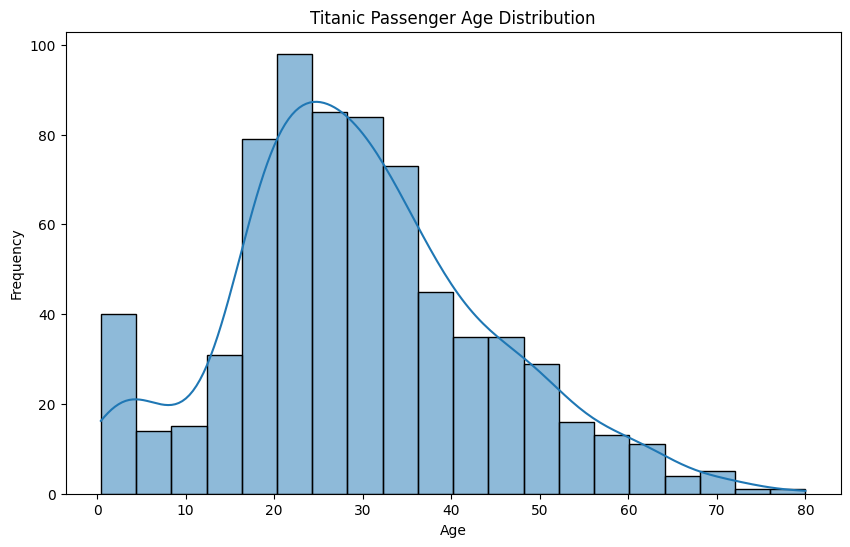

In [5]:
plt.figure(figsize=(10, 6))
sbn.histplot(train_df['Age'].dropna(), bins=20, kde=True)
plt.title('Titanic Passenger Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

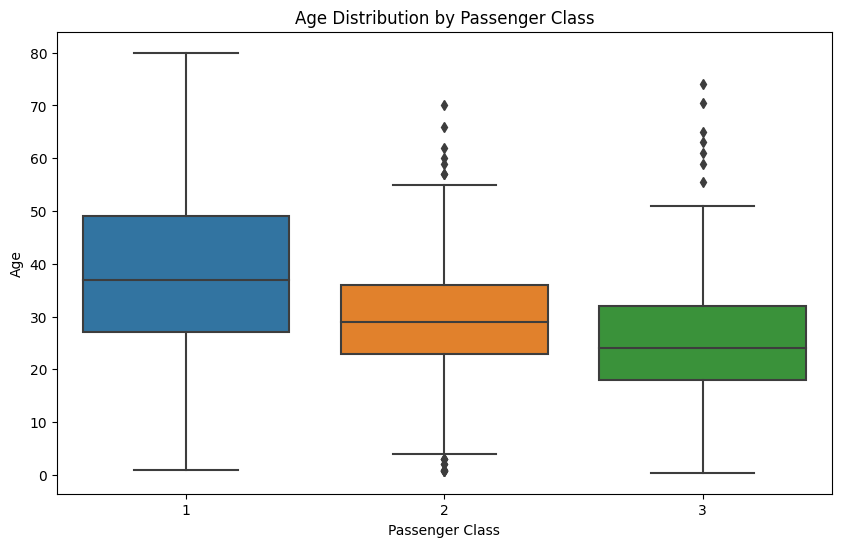

In [9]:
plt.figure(figsize=(10, 6))
sbn.boxplot(x='Pclass', y='Age', data=train_df)
plt.title('Age Distribution by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.show()

# #Pclass

In [ ]:
# Survival rate by Pclass
train_df.groupby(['Pclass'], as_index = False)['Survived'].mean()

# #Sex

In [ ]:
# Survival rate by sex
train_df.groupby(['Sex'], as_index = False)['Survived'].mean()

# #Family Size

 **Feature Engineering:** Family Size = person(1) + SibSp + Parch

***SibSp (Siblings/Spouses):*** This column indicates the number of siblings and spouses
traveling with the passenger. (Exm: 0: No siblings or spouses.)

***Parch (Parents/Children):*** This column indicates the number of parents and children 
traveling with the passenger. (Exm: 0: No parents or children.)

In [ ]:
train_df["Family_Size"] = 1 +  train_df["SibSp"] + train_df["Parch"] 
test_df["Family_Size"] = 1 +  train_df["SibSp"] + train_df["Parch"] 

train_df.head()

In [ ]:
# Survival rate by Family Size
train_df.groupby(["Family_Size"], as_index = False)["Survived"].mean()

# Result: highest rate = survival rate of those with a family size of 4  (%72)

In [ ]:
# Grouping the family size
family_map = {1: "Alone",
              2: "Small", 3: "Small", 4: "Small",
              5: "Medium",6: "Medium",
              7: "Large", 8: "Large", 9: "Large", 10: "Large", 11: "Large"
             }
train_df["Family_Size_Grouped"] = train_df["Family_Size"].map(family_map)
test_df["Family_Size_Grouped"] = train_df["Family_Size"].map(family_map)

In [ ]:
train_df.head()

In [ ]:
# Survival rate by Grouped Family Size
train_df.groupby(["Family_Size_Grouped"], as_index = False)["Survived"].mean()

**Result:** Those with a small family have a better chance of survival. It decreases if you are alone, and then in turn with the option of being in a large family.

In [ ]:
# Visualization for Grouped Family Size
plt.figure(figsize=(8, 5))
sbn.barplot(x='Family_Size_Grouped', y='Survived', data=train_df, palette='viridis')
plt.title('Survival Rate by Family Size Group')
plt.xlabel('Family Size Groups')
plt.ylabel('Survival Rate')


# #Age

In [ ]:
# Crate age ranges by grouping Ages into intervals 
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
train_df['AgeGroup'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, right=False)

# Calculate survival rate by gruped age
survival_rate = train_df.groupby('AgeGroup', observed=False)['Survived'].mean()

In [ ]:
# Visualizing for Grouped Age
plt.figure(figsize=(8,5))
sbn.barplot(x=survival_rate.index, y=survival_rate.values, palette='viridis')
plt.title('Survival Rate by Grouped Age')
plt.xlabel('Age Groups')
plt.ylabel('Survival Rate')

# edit x-axis labels
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

In [ ]:
train_df.head()

In [ ]:
# delete one column loaded twice by mistake
train_df.drop(columns=['Family_Size_Grouped'], inplace=True)

In [ ]:
# Check
train_df.head()

In [ ]:
train_df.groupby(["AgeGroup"], as_index = False, observed=False)["Survived"].agg(['count', 'mean'])

# #Ticket

In [ ]:
# Ticket Numbers:
train_df["Ticket"]

In [ ]:
# Access the actual main section of ticket numbers
train_df["TicketNumber"] = train_df["Ticket"].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))
test_df["TicketNumber"] = test_df["Ticket"].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))

In [ ]:
# Check
train_df.head()

In [ ]:
train_df.groupby(["TicketNumber"], as_index = False)["Survived"].agg(['count', 'mean']).sort_values('count', ascending = False)

# #Fare (Price of ticket)

In [ ]:
train_df.groupby(["Fare"], as_index = False)["Survived"].agg(['count', 'mean'])

# Handle with missing values

In [ ]:
train_df.isnull().sum()

In [ ]:
test_df.isnull().sum()

In [ ]:
# Fill in the missing Age values with K-NN
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
train_df[['Age']] = imputer.fit_transform(train_df[['Age']])


In [ ]:
# Fill in missing age values in the test_df 
test_df[['Age']] = imputer.fit_transform(test_df[['Age']])

In [ ]:
# Fill in the missing Cabin Values by taking advantage of other columns
train_df['Cabin'] = train_df.groupby(['Pclass', 'Embarked'])['Cabin'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))


In [ ]:
# Fill in the missing Cabin Values by taking advantage of other columns in Test data
test_df['Cabin'] = test_df.groupby(['Pclass', 'Embarked'])['Cabin'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))


In [ ]:
train_df.isnull().sum()

In [ ]:
# Ensure compliance by readjusting the index of the data frame
test_df = test_df.reset_index(drop=True)

In [ ]:
# Fill missing Cabin values with 'Unknown'
test_df['Cabin'] = test_df['Cabin'].fillna('Unknown')

# Find the most frequent value in the Embarked column
most_frequent_embarked = test_df['Embarked'].mode()[0]

# Fill missing Embarked values with the most frequent value
test_df['Embarked'] = test_df['Embarked'].fillna(most_frequent_embarked)

test_df.fillna({"Fare": test_df["Fare"].mean()}, inplace=True)

# Check again
print(f"Missing Values in train_df: {train_df.isnull().sum()}")
print(f"Missing Values in test_df: {test_df.isnull().sum()}")

# A few Corrections

In [ ]:
train_df["Age"]

In [ ]:
# Throw zeros after dot for Ages
train_df['Age'] = train_df['Age'].apply(lambda x: int(x))
test_df['Age'] = test_df['Age'].apply(lambda x: int(x))

# Check
print(train_df['Age'])
print(test_df['Age'])